In [1]:
import ROOT
import my_library.common_analysis_tools as ct
import my_library.constants as constants
import my_library.kinematic_cuts as cuts
import numpy as np

Welcome to JupyROOT 6.24/04


In [2]:
# ROOT.EnableImplicitMT()

In [3]:
def define_vanhove(channel, run_period, data_type, thrown=False, filtered=False):
    if data_type not in ['signal', 'data', 'phasespace']:
        return None

    if thrown: filtered=False
    df = ct.get_dataframe(channel, run_period, data_type, thrown=thrown, filtered=filtered)

    if not thrown:
        proton = 'p'
        if channel == 'pipkmks':
            pion = 'pip1'
            kaon = 'km'
        else:
            pion = 'pim1'
            kaon = 'kp'
    else: 
        proton = 'Proton'
        if channel == 'pipkmks':
            pion = 'PiPlus1'
            kaon = 'KMinus'
            ks = 'PiPlus2_{0} + PiMinus_{0}'
        else:
            pion = 'PiMinus1'
            kaon = 'KPlus'
            ks = 'PiMinus2_{0} + PiPlus_{0}'
        df = df.Define('ks_px', ks.format('px'))
        df = df.Define('ks_py', ks.format('py'))
        df = df.Define('ks_pz', ks.format('pz'))
        df = df.Define('ks_E', ks.format('E'))
        df = df.Define('ks_m', 'sqrt(ks_E*ks_E - ks_px*ks_px - ks_py*ks_py - ks_pz*ks_pz)')

    # define beam/target CM frame
    df = df.Define("beam_p4", "ROOT::Math::PxPyPzEVector(e_beam, 0, 0, e_beam)")
    df = df.Define("target_p4", "ROOT::Math::PxPyPzEVector(0, 0, 0, 0.938272)")
    df = df.Define('cm_boost_vector', '-1*(beam_p4 + target_p4).BoostToCM()')
    # recoil proton, kkpi, kk, pion lab frame vectors
    df = df.Define('p_p4', f'ROOT::Math::PxPyPzEVector({proton}_px, {proton}_py, {proton}_pz, {proton}_E)')
    df = df.Define(f'{pion}_p4', f'ROOT::Math::PxPyPzEVector({pion}_px, {pion}_py, {pion}_pz, {pion}_E)')
    df = df.Define(f'{kaon}_p4', f'ROOT::Math::PxPyPzEVector({kaon}_px, {kaon}_py, {kaon}_pz, {kaon}_E)')
    df = df.Define(f'ks_p4', 'ROOT::Math::PxPyPzEVector(ks_px, ks_py, ks_pz, ks_E)')
    # boosting to CM frame
    df = df.Define('cm_boost', "ROOT::Math::Boost(cm_boost_vector)")
    df = df.Define('beam_p4_cm', 'cm_boost(beam_p4)')
    df = df.Define('target_p4_cm', 'cm_boost(target_p4)')
    df = df.Define('p_p4_cm', 'cm_boost(p_p4)')
    df = df.Define(f'{pion}_p4_cm', f'cm_boost({pion}_p4)')
    df = df.Define(f'{kaon}_p4_cm', f'cm_boost({kaon}_p4)')
    df = df.Define('ks_p4_cm', 'cm_boost(ks_p4)')
    # define vanhove variables
    df = df.Define('q1', f'{pion}_p4_cm.Pz()')
    df = df.Define('q2', f'{kaon}_p4_cm.Pz()')
    df = df.Define('q3', 'ks_p4_cm.Pz()')
    df = df.Define('q4', 'p_p4_cm.Pz()')
    df = df.Define('z', 'q1')
    df = df.Define('x', 'sqrt(3.0/8.0)*(q3-q2)')
    df = df.Define('y', 'sqrt(1.0/8.0)*( (2.0*q1) + (3.0*q2) + (3.0*q3) )')
    df = df.Define('theta_vanhove', 'TMath::RadToDeg() * atan2(sqrt(x*x + y*y), z)')
    df = df.Define('phi_vanhove', 'TMath::RadToDeg() * atan2(y, x)')



    return df

In [4]:
df_pipkmks = define_vanhove('pipkmks', '2017', 'data')
df_pimkpks = define_vanhove('pimkpks', '2017', 'data')


In [5]:
# hist_pipkmks = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo2D(('vanhove_pipkmks', 'Van Hove #theta vs #phi for #pi^{+}K^{-}K_{S}^{0}', 100, -180, 180, 100, 0, 180), 'phi_vanhove', 'theta_vanhove')
# hist_pimkpks = df_pimkpks.Filter(cuts.KSTAR_ALL_CUT_PIMKPKS).Histo2D(('vanhove_pimkpks', 'Van Hove #theta vs #phi for #pi^{-}K^{+}K_{S}^{0}', 100, -180, 180, 100, 0, 180), 'phi_vanhove', 'theta_vanhove')
# # hist_theta_pipkmks = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo1D(('vanhove_theta', 'Van Hove #theta for #pi^{+}K^{-}K_{S}^{0}', 100, 0, 180), 'theta_vanhove')
# hist_theta_pipkmks = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo1D('theta_vanhove')
# hist_kkpi_pipkms = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo1D(('pipkmks', 'M(KK#pi)', 90, 1.1, 2.0), 'pipkmks_m')

hist_pipkmks = df_pipkmks.Histo2D(('vanhove_pipkmks', 'Van Hove #theta vs #phi for #pi^{+}K^{-}K_{S}^{0}', 100, -180, 180, 100, 0, 180), 'phi_vanhove', 'theta_vanhove')
hist_pimkpks = df_pimkpks.Histo2D(('vanhove_pimkpks', 'Van Hove #theta vs #phi for #pi^{-}K^{+}K_{S}^{0}', 100, -180, 180, 100, 0, 180), 'phi_vanhove', 'theta_vanhove')
# hist_theta_pipkmks = df_pipkmks.Filter(cuts.KSTAR_ALL_CUT_PIPKMKS).Histo1D(('vanhove_theta', 'Van Hove #theta for #pi^{+}K^{-}K_{S}^{0}', 100, 0, 180), 'theta_vanhove')
hist_theta_pipkmks = df_pipkmks.Histo1D('theta_vanhove')
hist_kkpi_pipkms = df_pipkmks.Histo1D(('pipkmks', 'M(KK#pi)', 90, 1.1, 2.0), 'pipkmks_m')
hist_ppi = df_pipkmks.Histo1D(('m_ppi', 'M(p#pi)', 200, 0.8, 3.0), 'ppip_m')

In [ ]:
cols = ROOT.vector('string')(); cols.push_back('q4'); cols.push_back('q3'); cols.push_back('q2'); cols.push_back("x"); cols.push_back("y"); cols.push_back("z"); cols.push_back("theta_vanhove"); cols.push_back("phi_vanhove");
print(df_pipkmks.Display(cols, 100).Print())

None
q4         | q3            | q2           | x             | y         | z            | 
0.65796057 | 2.2507212     | 4.5660666    | -1.4178537    | 7.4413932 | 0.29853749   | 
1.2041638  | 2.6022086     | 3.8955861    | -0.79202870   | 7.5911225 | 0.98877637   | 
4.7264514  | 0.79371969    | 0.63369851   | 0.097992555   | 2.9052758 | 1.9675532    | 
0.28092952 | 1.9490393     | 4.8861978    | -1.7986349    | 8.3832070 | 1.6027894    | 
0.32569841 | 4.4118670     | 1.6249830    | 1.7066109     | 7.8007049 | 1.9765877    | 
0.37786717 | 1.8562608     | 4.6453531    | -1.7079632    | 9.0120986 | 2.9926112    | 
4.6913676  | 3.9919338     | 0.18801939   | 2.3294124     | 5.1905535 | 1.0706214    | 
0.67600446 | 0.42060134    | 5.7504546    | -3.2638552    | 7.7953183 | 1.7676609    | 
1.0592559  | 0.84202132    | 0.39095032   | 0.27622345    | 4.8182698 | 4.9646051    | 
1.1570699  | 0.33809395    | 5.8987456    | -3.4051898    | 7.5982719 | 1.3903198    | 
1.4025370  | 0.011923869   

Info in <Print>: Only showing 6 columns out of 8



In [ ]:
# stats_phi = df_pipkmks.Stats('phi_vanhove')
# stats_theta = df_pipkmks.Stats('theta_vanhove')
# print(stats_phi.Print())
# print(stats_theta.Print())

In [ ]:
c = ROOT.TCanvas('c', 'c', 800, 800)
c.Divide(1, 2)
c.cd(1)
hist_pipkmks.Draw('colz')
c.cd(2)
hist_pimkpks.Draw('colz')
c.Draw()


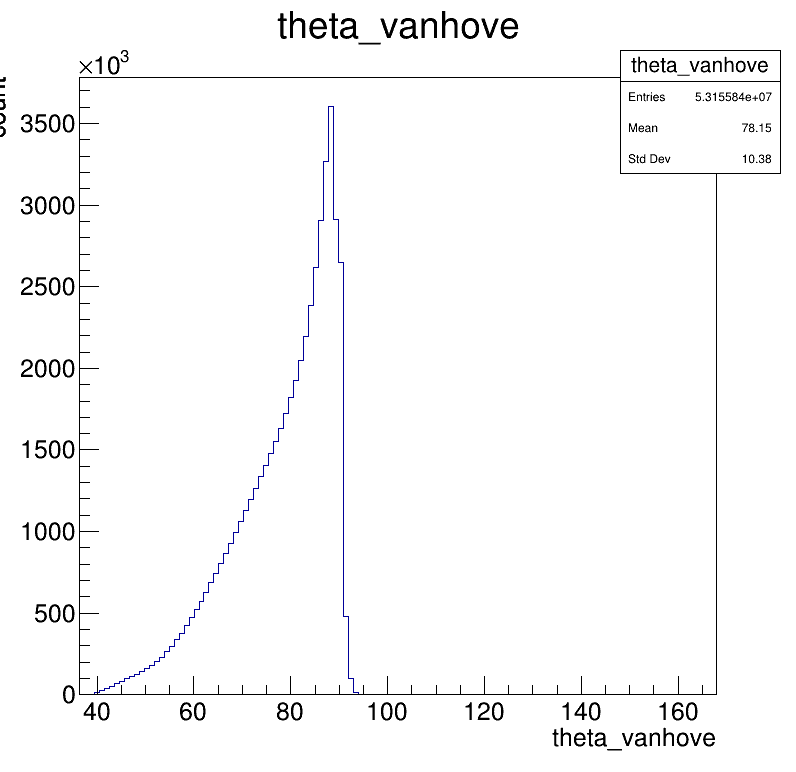

In [ ]:
c.Clear()
hist_theta_pipkmks.Draw()
c.Draw()

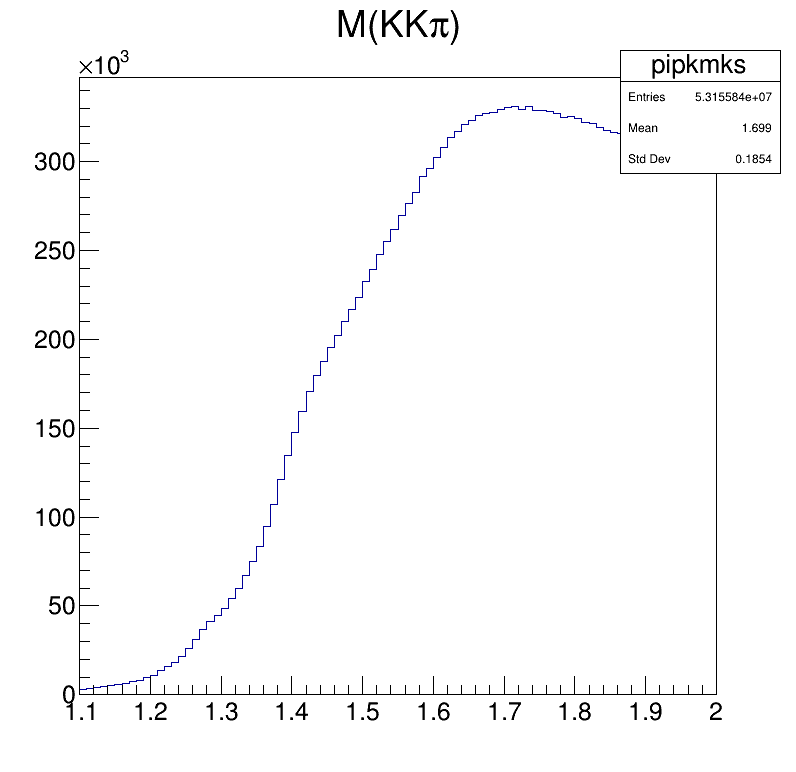

In [ ]:
c.Clear()
hist_kkpi_pipkms.Draw()
c.Draw()

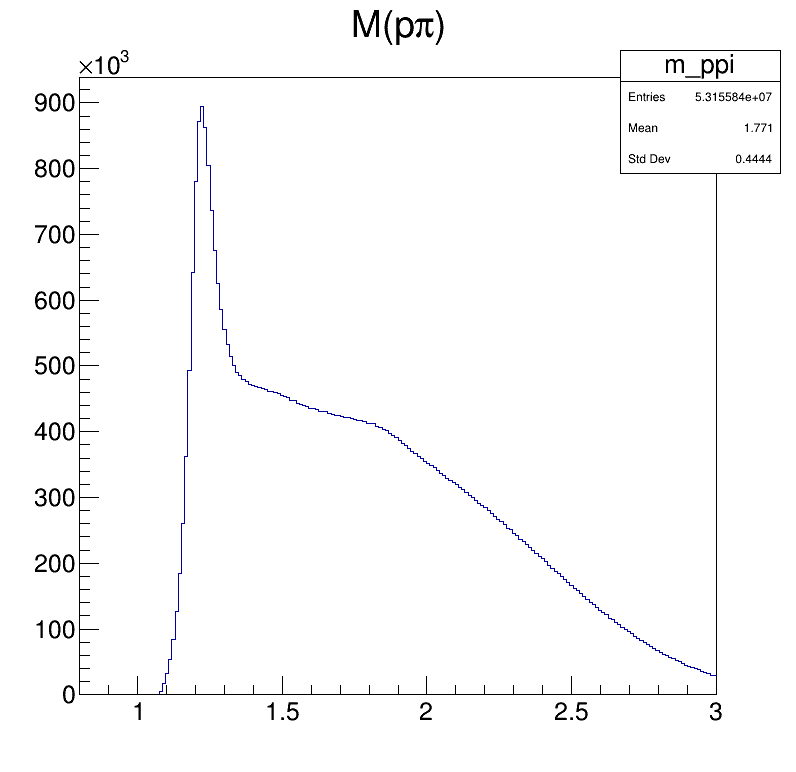

In [ ]:
c.Clear()
hist_ppi.Draw()
c.Draw()